In [2]:
import numpy as np
from matplotlib import pyplot as plt

<h2>Demonstration of a hadamard gate on single qubit</h2>
<img src='resources/nate/single_hadamard.png' width="200"/>

The hadamard is represented as a 2x2 matrix operator $\frac{1}{\sqrt(2)} \begin{bmatrix}1&1\\1&-1 \end{bmatrix}$

A qubit is provided, initialized at state $\ket{\psi} = \ket{0}$
Hadamard is applied on the qubit, throwing it into superposition $\frac{\ket{0}+\ket{1}}{\sqrt{2}}$

A measurement is then taken, collapsing the qubit to either state $\ket{0} = \begin{bmatrix} 1 \\ 0\end{bmatrix}$ or $\ket{1} = \begin{bmatrix}0\\1\end{bmatrix}$ with probability $|\frac{1}{\sqrt{2}}|^{2} = 0.5$ for both states.

This measurement is represented as matrix multiplication by $\ket{0}\bra{0} = \begin{bmatrix} 1 & 0 \\ 0 & 0\end{bmatrix}$ or $\ket{1}\bra{1} = \begin{bmatrix} 0 & 0 \\ 0 & 1\end{bmatrix}$

In [126]:
#define operators and gates

def hadamard(qbit):
    H = np.array([[1,1],[1,-1]])/np.sqrt(2) #hadamard gate
    return np.matmul(H, qbit)

def measure(qbit, count):
    #define probability array for collapses
    probs = np.abs(qbit.flatten())**2
    #define measurement operators
    m1 = np.array([[1,0],[0,0]])
    m2 = np.array([[0,0],[0,1]])
    #simulate count measurements
    measurements = np.random.choice([0,1], p=probs, size=count)
    return measurements

def normalize(qbit):
    norm = np.linalg.norm(qbit)
    norm = 1 if norm == 0 else norm
    normed = qbit / norm
    return normed
    
#demonstrate effect of single hadamard gate and measurement
def runSingleHadamard(qbits, shots):
    measured = np.array([])
    for qbit in qbits:
        appliedH = hadamard(qbit)
        measured = measure(appliedH, shots)
        #normed = normalize(measured)
        print("Input: ",qbit.T, "Superposition: ", appliedH.T, "Measurement: ", measured.T[0]) #print horiz for better viewing
    return measured
    
#demonstrate double hadamard and measurement
def runDoubleHadamard(qbits, shots):
    measured = np.array([])
    for qbit in qbits:
        appliedH = hadamard(qbit)
        appliedH2 = hadamard(appliedH)
        measured = measure(appliedH2, shots)
        #normed = normalize(measured)
        print("Input: ",qbit.T, "Superposition: ", appliedH.T, "Measurement: ", measured.T[0])
    return measured

In [210]:
#plot results in a bar chart
def plot(measurements):
    #preplot data
    count0 = np.sum(measurements == 0)
    count1 = np.sum(measurements == 1)
    total = count0 + count1
    percent0 = f"{round(count0/total*100, 2)}%"
    percent1 = f"{round(count1/total*100, 2)}%"
    #plots
    plt.bar(['0','1'], [count0, count1], color=['red', 'blue'], label=[percent0, percent1])
    plt.xlabel("Measurement")
    plt.ylabel("Count")
    plt.legend()
    plt.title("Circuit measurements")
    plt.show()

Input:  [[0 1]] Superposition:  [[ 0.70710678 -0.70710678]] Measurement:  0
Input:  [[0 1]] Superposition:  [[ 0.70710678 -0.70710678]] Measurement:  1


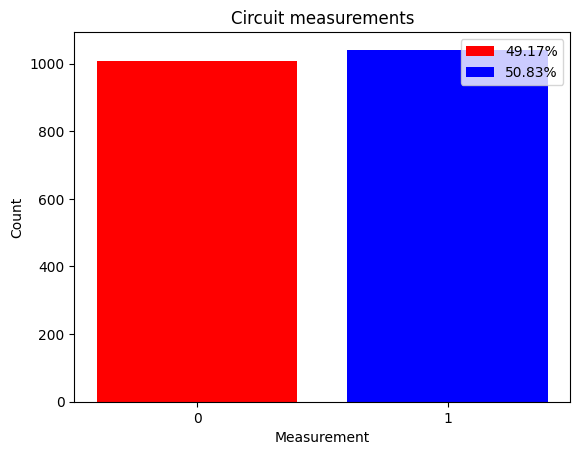

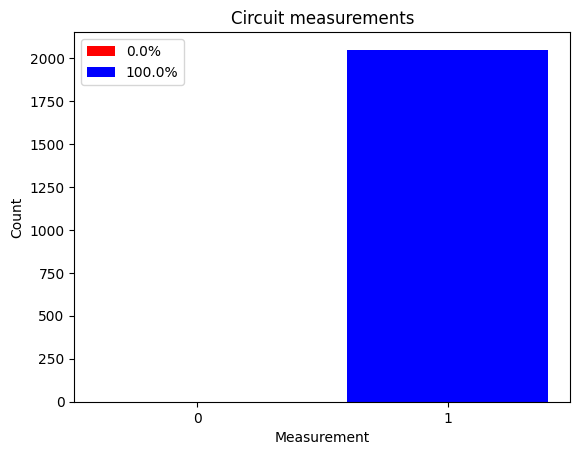

In [214]:
#model qubits as 2x1 array
q0 = np.array([[1],[0]]) #initialized to |0)
q1 = np.array([[0],[1]]) #init to |1)
singleHOutput = runSingleHadamard([q1], 2048)
doubleHOutput = runDoubleHadamard([q1], 2048)

#plot outputs
plot(singleHOutput)
plot(doubleHOutput)